In [1]:
#hide
from fastbook import *

# Image Classification

In the previous Chapter we learnt about neural networks from scratch.We discussed about activation 
functions,training epochs,nonlinearity in neural nets etc.We also created an optimizer.Before that
in Chapter 2 we already discussed about building an Image Classifier and how to create an deploy the 
model.It's not only important to learn building models but also very important to make it work,fine 
tune it,figure out the correct set of parameters,find places where it is making wrong predictions,
find problems and fix them.
Previously in first chapter we trained simple NLP,Vision,Collaborative filtering and tabular data 
models.But we are yet to understand how these models work and the potential architecture behind the 
model.Now from hereon we would be discussing about each module in detailed and would learn how each 
model works and what can we do make these models better.
We would learn about different types of layers,optimizers,layers in architectures,labelling techniques
etc.Let's learn about Image Classification a little more..

## From Dogs and Cats to Pet Breeds

In first chapter we had built an Image Classifier of dogs vs cats.Pets Dataset is very large and it
also contain images for different breeds of dogs,so we can actually build a classifier to identify 
different pet breeds from the same.Let's build the same using the PETS dataset.

We follow the same method to get the PETS dataset using untar_data and decompressing it and set the 
path for the dataset.

In [2]:
#Importing fast.ai vision library
from fastai.vision.all import *
path = untar_data(URLs.PETS)#Downloading dataset and it's setting its path

Now we need to understand the organization of this dataset.How it is arranged.It's not that always
all the datasets will be arranged in different folders according to their classes or that filename
would give us labels for the Image.The two general ways in which dataset can be arranged is:-
1.Individual files of data items such as Images or text are arranged in folders with filenames
which describe the class or labels for the files.
2.Sometimes a table in CSV format is provided which where every row contains filename and other rows
may contain information about labels or path to label files.Sometimes they also indicate if the 
particular file is a part of validation set or training set.

In [3]:
#hide
Path.BASE_PATH = path

To see the contents of the dataset let's use ls() method

In [4]:
#See subdirectory inside the path
path.ls()

(#2) [Path('annotations'),Path('images')]

Our dataset contains "images" and "annotations".The "annotations" folder contains information about
the location of the pets and not about the labels of the images.We are required to do Image Classifier
here therefore annotations folder doesn't contain any information of our need.

Let us see what is inside images folder using.ls() property..

In [5]:
#Get the path to all images using .ls() property
(path/"images").ls()

(#7393) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg'),Path('images/Abyssinian_100.mat'),Path('images/Abyssinian_101.jpg'),Path('images/Abyssinian_101.mat'),Path('images/Abyssinian_102.jpg'),Path('images/Abyssinian_102.mat'),Path('images/Abyssinian_103.jpg'),Path('images/Abyssinian_104.jpg')...]

The output above looks like a list."L" is an enahanced version of List.When a "L" type object is 
displayed it is displayed as above.The number of elements are displayed first with "#" and then within
"[]" the items are displayed.From the filenames we can observe that they denote the Breed of the dog 
along with the "Image number too".We can extract the breed names from these file names.Some breed 
names also contain multiple words.So simply extracting everything before "_" won't help.Let's 
try extracting breed name from a file name..

In [6]:
#picking up path for first image
fname = (path/"images").ls()[0]

In [7]:
#Get the file name
fname.name

'Abyssinian_1.jpg'

Regular expressions are not common only in Python but other languages as well.In python it is like a 
simple string containing some characters or letters according to the reg(regular expression) rules.
It specifies what particular parts from the test string has to be extracted.

We should try to practice regular expression using examples.Let's use "findall" method to extract the
breed name from the filename.

In [8]:
#Extracting the breed name from the file name
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

The abov expression r'(.+)_\d+.jpg$' extracts all the characters till the last underscore character 
after which there are some nos and a .jpg extension is there.We can see that we can extract the breed
name using reg.Let's use it to label our whole dataset now...Fastai provides many classes for 
labelling.RegexLabeller is used for labelling the Images.We use DataBlock API here for setting up our
data and then we load it into dataloaders using dataloaders method.

In [9]:
#Creating DataBlock for Pets dataset..
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),#Since input is Image and output is class
                 get_items=get_image_files, #Input data is images,so we use get_image_files
                 splitter=RandomSplitter(seed=42),#splitter for training and validation split
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),#labels using regular 
                 #expression stored in "name" variable.
                 item_tfms=Resize(460),#Resizing all images to bring them to same size
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)) #Image augmentation transforms
dls = pets.dataloaders(path/"images",num_workers=0) #getting dataloaders

We also do some image augmentation in DataBlock call.
item_tfms=Resize(460)
batch_tfms=aug_transforms(size=224,min_scale=0.75)
This is called "Presizing".Before dividing it into batches,we Resize it to same size and then batch-
wise transforms are applied.Presizing is an Image augmentation strategy which causes minimal data
destruction and important features of images are also not lost.

## Presizing

Images should be of same size so that when they are processed on GPU they are of same size.During 
Image augmentation,the number of augmentation transforms should be minimum and the images should 
have uniform size for efficient processing.
During Image Augmentation ,after resizing it to a definite size,some data augmentation transforms may 
cause loss of important data or degrade image quality.To avoid this,Presizing:-
1.Resize images to larger dimension.
2.Combining all augmentation transforms into one and apply them together on Images rather than 
individually applying transforms.
In the first steps Images are resized to larger dimension so that they have enough margin space to
apply further augmentation transforms without any empty zones.It resizes Image to square shape and 
and then does random cropping.The crop size is such that it covers entire width or entire height 
either of the both.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="images/att_00060.png">

In the above Image,there are two steps done:
1.item_tfms:-This transform is applied to each item before it is copied to GPU.Makes all images of 
same size and a random crop area is chosen in training set.On validation set,the center square of the
image is selected.
2.Random crop:-This is passed in batch_tfms,it is applied to whole batch on GPU,so its faster.On 
training set,the random crop and other augmentation are done first.
We pass Resize through item_tfms with a large size and RandomResizedCrop is passed as batch_tfms but
with a smaller size.As we had included min_scale in aug_transforms before,RandomResizedCrop is added 
to it automatically.

Below example shows the difference between the resolution and quality of the Image after applying
aug_transforms individually or one after other(approach used by different deep learning libraries).The
images are zoomed,interpolated,rotated and then interpolated on left.We basically compare the fastai's
augmentation strategy with the traditional approach.

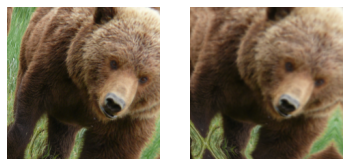

In [10]:
#Comparison of fastai's augmentation strategy and the traditional approach.
#Creating DataBlock for fastai augmentation approach 
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),#input and output blocks
                   get_y=parent_label,#labeller for labels(using parent folder)
                   item_tfms=Resize(460))#Resizing to large dimension
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)#dataloaders with batch 
#size=8
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()#getting image from validation set
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)#downsizes the image to small matrix
x1 = x1.rotate(draw=30, p=1.)#rotate image
x1 = x1.zoom(draw=1.2, p=1.)#zoom image
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)#change angle to view image

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)]) #augmentation transforms for 
#fastai approach
x = Pipeline(tfms)(x) #forming pipeline for the transformations
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])#displaying Fastai Augmented Image
TensorImage(x1[0]).show(ctx=axs[1]);#displaying traditional augmentation

We can clearly see that the image on right is not well defined and the padding produces artifacts in
the left side at the bottom.Further we would see that presizing helps in improving accuracy of the 
model and also speeds up the training process.
We had previously also seen that using show_batch function of dataloaders we can display the data 
before training the model.Let's see that

### Checking and Debugging a DataBlock

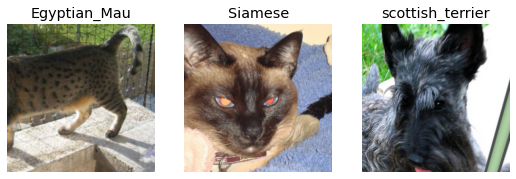

In [11]:
dls.show_batch(nrows=1, ncols=3)

We can see that every image is labelled correctly.This is also very important task in preparation of
training data.
Many times Data Scientists are not aware about the domain of the data they are working with.We may not
be aware about the knowledge for pet breeds.In that case one will use Google Images to check if the
images are labelled correctly or not.

When we build DataBlock we pass many arguments through it.In case if we miss something or we made some
mistake,we can debug it using the summary method.It tries to create a batch from the data in the path
you pass through it.If we don't use Resize transform Images would be of different sizes and cannot be
split into minibatches then.Below code cell shows how can we debug the DataBlock and it throws error
when do not mention Resize transform in item_tfms.

In [12]:
#Creating DataBlock without Resize
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\kruti\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\kruti\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30, dtype=torch.int32)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30, dtype=torch.int32))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 199, 300] at entry 1

In the DataBlock pass above,we did not pass Resize Transforms as a result of which GPU receives images
of different sizes and it is not able to collect those samples in batch because it recieves tensors of
different sizes.

Once we are done with Data Augmentation,we can train our model.We should always start from simple 
model.Sometimes we think that simple models won't work on our problems and we spend our time in 
training model for a long time when actually a simple model could be useful.Let's try training a 
simple resnet34 architecture.

In [13]:
#No loss function passed.
#creating learner by passing dataloaders(dls)
learn = cnn_learner(dls, resnet34, metrics=error_rate,num_workers=0)
learn.fine_tune(2)#training model for 2 epochs..

epoch,train_loss,valid_loss,error_rate,time
0,1.510523,0.339519,0.101489,02:57


epoch,train_loss,valid_loss,error_rate,time
0,0.507481,0.330973,0.104871,03:14
1,0.330347,0.216427,0.069689,03:14


We trained the above model for 2 epochs.It shows some metrics such as error_rate and train_loss and 
valid_loss afte each epoch.One epoch in general means when all the images in the dataset pass through
the model in one cycle.
We can recall this thing that loss is the function we used to optimize our model to update our 
parameters.We haven't mentioned the loss function in the above code shell.Still the model seems to be 
working fine,what fastai does is that it selects an appropriate loss function based on the type of
data and model we use.Since here we have input as Image data and output is categorical class so fastai
chooses it as default "cross_entropy_loss".

In [14]:
learn.loss_func#Cross entropy Loss

FlattenedLoss of CrossEntropyLoss()

Let's see what is Cross-Entropy Loss...

## Cross-Entropy Loss

In previous Chapter for mnist loss also we had used cross entropy loss as the loss function.It is apt 
for loss function because:-
1.Works for multiclass or multilabel problems too.
2.It is much faster during training.
Let's see how it works when the dependent variable has more than 2 classes

### Viewing Activations and Labels

Let's see our actual data and the activations:-
We can view the dependent and independent variables in one batch using dls.one_batch() method of 
dataloaders..

In [15]:
#One batch of dataloader
x,y = dls.one_batch()

Above one_batch method returns a set of values for dependent and independent variables in a mini
-batch.

In [16]:
y

TensorCategory([14,  3, 18, 34, 36, 22,  9,  2,  8, 11, 23,  2, 23, 22,  8,  6, 15, 26, 35, 16,  9, 30, 13, 11, 14,  1, 18, 17, 23,  6, 28, 24, 17, 29, 31,  5, 26,  6, 36,  2, 25, 25, 11, 16,  5, 29, 35, 20,
        32, 12, 36,  8, 36,  0,  6, 15, 30, 27, 19,  9,  4, 32, 23,  4], device='cuda:0', dtype=torch.int32)

Now y are the dependent variables we can see that these are numbers between 0 and 36 which represent 
the 37 pet breeds respectively.We can get the predictions using learn.get_preds function.It takes as 
input either the index for the data in the training or validation set.A simple list with the batch
can be passed to get the predictions.It returns targets and predictions both.Targets and predictions 
are returned by default but since we are concerned with predictions only and not targets so we assign 
them by putting "_".

In [ ]:
dls.vocab[0]

.vocab method gives the list of all the unique dog breeds in the dataset.We can get the first element
of the list by indexing.

In [17]:
#Prediction for first batch
preds,_ = learn.get_preds(dl=[(x,y)]) #prediction for first mini batch
preds[0]#predictions for first row(37 rows would be there)

tensor([5.4293e-06, 3.9754e-06, 7.0318e-06, 3.3152e-07, 2.1129e-07, 1.9608e-06, 8.0601e-07, 5.4954e-06, 5.4850e-06, 2.0334e-07, 1.0109e-06, 7.5169e-09, 8.6944e-07, 9.7012e-06, 9.9554e-01, 4.2759e-03,
        9.9719e-06, 4.3771e-08, 2.9716e-05, 1.3199e-06, 4.4937e-06, 1.0585e-06, 1.1892e-06, 2.2783e-06, 1.3851e-06, 2.8065e-06, 1.4465e-05, 5.4052e-06, 3.9683e-06, 2.7639e-07, 3.3124e-05, 2.9377e-06,
        5.1387e-06, 1.3264e-05, 4.3918e-06, 6.3519e-07, 4.1373e-06])

Above we have the predictions.These are 37 probabilities corresponding to the 37 species with values 
between 0 and 1.These are probabilities for a single image so if they are added the sum would be 1.
Let's see..

In [18]:
len(preds[0]),preds[0].sum() #Sum of the predictions is 1..

(37, tensor(1.))

But how do we get the activations between 0 and 1 such that the sum of all probabilities is 1 because 
predictions can be any real number.For the same,softmax activation function is used..

### Softmax

In the breeds classification model,softmax is applied in the final layer so as to make activations 
between 0 and 1.Previously also we had discussed about sigmoid function which maps values between 0 
and 1.Softmax is also like sigmoid.

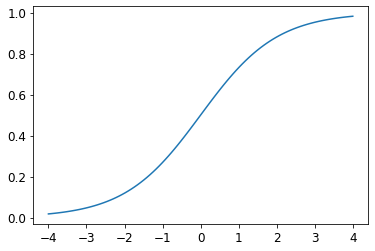

In [19]:
#Extension of sigmoid
plot_function(torch.sigmoid, min=-4,max=4)

Sigmoid can be applied to a single column of activations from a neural network and can give us column
of numbers between 0 and 1.But when there are more classes in the target variable,then there will be 
many activations and not just a single column.For each category there will be one activation.We can 
also create a neural net for predicting if the number is 3 or 7 by giving two activations for 3 and 7
respectively.Let us just take random values having deviation of 2 and having 6 images and 2 possible
categories for all the images.

In [20]:
#hide
torch.random.manual_seed(42);

In [21]:
#Initializing activation values for 
acts = torch.randn((6,2))*2 #generate a tensor of (6,2) shape representing activations for 6 images
#with 2 categories
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

Since we are generating random numbers here,these can be anything and not necessarily they add upto 1.
Let's see if they add upto 1 after applying sigmoid function.

In [22]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

After applying sigmoid the rows do not add to 1.Previously in MNIST digit classifier,since it was a 
Binary classification problem it produces a single activation indicating the relative probability of
the image being 3 over 7.Binary problems can also be extended to classification problems with more no 
of categories.Like in the bear classifier,it returns one activation for each category.
As mentioned activations simply indicate the relative confidence of the input being in either of the 
classes.The individual values don't matter instead what matters is their relative difference.
When we applied sigmoid to the two activation data,we don't get values addinh upto 1.But we can just 
take the difference between the two activations(two columns) and then take sigmoid of those values.

In [23]:
#Sigmoid applied to the differences of the two columns
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column will then be the values after subtracting 1 from these values(sigmoid of the differe
nces between the two columns).This can be done for more than 2 categorical classes too.The "softmax"
function allows us to do that.Let's apply softmax directly to the two activation model..

In [24]:
#applying softmax to the activations for 2 classes.
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

We can observe from the above tensor that both the columns add to 1 for each row(image).This shows
that these are the relative probabilities.

Softmax is considered as the multiclass equivalent of the sigmoid function.It is used everytime we 
have more than two categories and the probabilities for all the categories add to 1.There are many 
such functions in which all the values are between 0 and 1 and all the values add to 1.No other 
function is similar to sigmoid but for which is smooth.
Let's see how softmax is calculated..Suppose we have three output activations and we calculate softmax
for these..

<img alt="Bear softmax example" width="280" id="bear_softmax" caption="Example of softmax on the bear classifier" src="images/att_00062.png">

We have raw predictions from the neural net in the output column.Next we apply exponential to ensure
that all the values are positive and then while applying softmax we divide them by the sum so as to 
get the values between 0 and 1 and get probabilities.If one activation is greater than the other,
taking exponents amplifies it and then we divide it by sum it becomes close to 1 with highest 
probaility.Ideally softmax picks up one class from the others by giving more scores to it.

Softmax makes up one part of the cross entropy loss.Lets look at "log likelihood".

### Log Likelihood

In the previous chapter,we calculated the loss for the MNIST database using the following function:-
    ```python
    def mnist_loss(inputs, targets):
        inputs = inputs.sigmoid()
        return torch.where(targets==1, 1-inputs, inputs).mean()
    ```
There sigmoid is applied to the predictions to get the values between 0 and 1.Now we need to move to
"softmax" as we classify into more than two categories.The activations would be between 0 and 1 in 
each column and the sum across all columns for each row will also be 1.The targets are integers 
between 0 and 36 in case of pet breeds.
In the binary classification example,we used torch.where to choose between inputs and 1-inputs.Now we 
treat the problem as an activation problem with 2 columns,one with inputs and other 1-inputs.We will 
just select appropriate column.Before implementing the same with pet breeds let us implement it with 
a random binary problem with 2 activation columns for 6 rows.

In [25]:
#The targets(0,1 are the two classes)
targ = tensor([0,1,0,1,1,0])

Below are the activations after passing then through softmax as all the columns across each row adds 
to one.Now we need to select appropriate columns from the both for each row.It can be done by tensor
indexing.

In [26]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

We create a separate variable for indexes with no of elements in targets.And it selects the 
appropriate activation column.To understand what's exactly happening..Let's see.

In [27]:
#Indexes for tensor indexing
idx = range(6)
sm_acts[idx, targ]#selecting appropriate activation column from the two..

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

How are these columns selected??To see what is happening ,we put all the columns together in a table.
The first two columns are activations for 3 and 7.Next are the targets,then row index and then the 
loss which was shown above

In [28]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"]) #Creating dataframe with the activations data
df['targ'] = targ #the target variable
df['idx'] = idx #the row index
df['loss'] = sm_acts[range(6), targ] #the loss
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


All the other columns in the above table are same as defined before only.But the last column is not.It
is calculated by taking target and index columns as indices into the matrix with 3 and 7 columns.
This is what is done by sm_acts[targ,idx] also.
This works for more than 2 columns also.If we were to classify all digits then there would be 
activation column for every digit from 0 to 9 for every row index.Target would be numbers from 0 to 9.
Since we would apply softmax function to the activations they would sum to 1 only thus there would be 
loss for each predictions which will show how well or accurate our prediction is.

The loss is calculated using the column with correct label only.Pytorch also provides a function which
works same as sm_acts[idx,targ] except for the fact that it takes negative as input as it applies log
afterwards and for that numbers should be positive.The function is called nll_loss(Negative log 
likelihood).

In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

We can see that nll_loss and the negative of sm_acts[idx,targ] give the same output.

In [30]:
#nll_loss by Pytorch
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

Though the name of this function is "nll_loss"(negative likelihood loss) but it does not take any log.
let's see what advantage taking log can offer..

### Taking the Log

In the above section we saw that Pytorch's nll_loss is used as a loss function for problems with more
than two categories.We use probabilities to calculate loss and that probabilities are always between 0
and 1.The model won't find any much difference between 0.99 and 0.999.These numbers are close but 
0.999 is also 10 times more probable than 0.99.To map numbers between 0 and 1 to minus infinity till
infinity,log is taken.Not defined for negative values.. and has negative values between 0 and 1.Below
is the plot of the function.

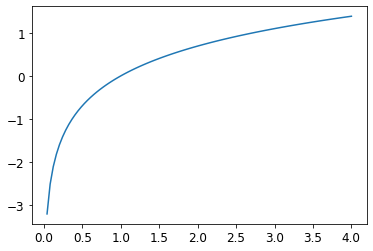

In [31]:
#Plotting logarithm using plot_function
plot_function(torch.log, min=0,max=4)

A property of logarithm is log(a)+log(b)=log(a*b).It shows that loagrithm increases linearly when the 
numbers increase exponentially.It is used in richter scales for measuring earthquake intensity,noise
levels in dB,in financial charts.This property is also used very much in deep learning because 
operations like multiplication can create very small or very large numbers so when we take log of 
those numbers it will result in addition operation,which won't result in very high or very small nos.



We take logarithm of the probabilities and then take mean of them which gives us the negative log 
likelihood loss.The Pytorch function "nll_loss" doesn't take log as it assumes that we have already 
taken the log after applying softmax function.So Pytorch provides one more class which actually takes
logarithmic mean of the probabilities and it is called "Cross Entropy Loss".It is available as 
nn.CrossEntropyLoss().Since it is a class we can create an instance of it and then pass the 
activations and targets and it will return the mean loss, a scalar value.

In [32]:
#Creating instance of the CrossEntropyLoss()
loss_func = nn.CrossEntropyLoss()
#This behaves like a function

Pass the targets and activations through the object.

In [33]:
#passing targets and activations through loss_func
loss_func(acts, targ)
#acts-activations
#targ-targets

tensor(1.8045)

Below we can see that cross_entropy is also provided by the pytorch functions.Actually pytorch loss
functions are found in two forms,one is under the nn module as we had mentioned before,other is pure
functional form accessible through F.

In [34]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In the previous code cell we used pure function "F" provided by fastai.
Both the functional form as well as the class form of the Pytorch functions gives the same answer 
when the same targets and activations are passed.Both are same but class version is more used while 
building models.Both are used extensively.Let's try creating an object to instantiate 
nn.CrossEntropyLoss.Also Pytorch loss functions generally take mean of all the items' losses together.
"reduction=none" is used to avoid calculating the mean.

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

Though loss function tells us how well our model is doing at each stage,but it doesn't tell us in 
real that how good our overall model is.Previously also in Machine Learning we interpreted Our 
classification results using metrics such as accuracy,precision,recall or confusion matrix.Let's see
how can we interpret our results..

## Model Interpretation

Models performance cannot be interpreted directly from Loss Functions as they are used for optimizing 
and differentiating.That's why metrics such as accuracy,error_rate,precision etc are used for judging
model's performance.The accuracy of our model is already very good.But there is still some error since
the accuracy is not 100%.We can know where our model is making some mistakes and where our model is 
doing good..

We see confusion matrix to see where the model is misclassifying the classes...

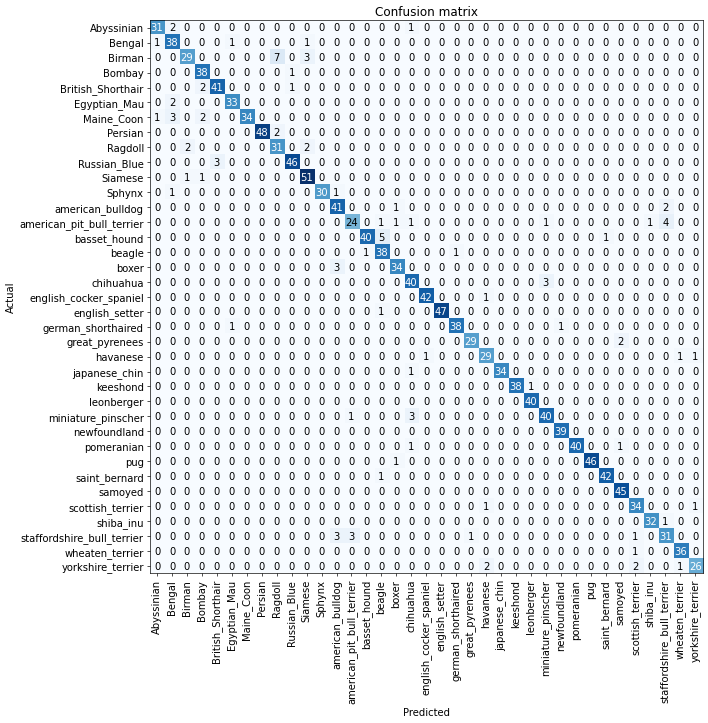

In [36]:
#building confusion matrix from our trained model.
interp = ClassificationInterpretation.from_learner(learn)
#plot confusion matrix 
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

As mentioned before that Confusion matrix is error matrix of size of the number of categories in our
dependent variable and shows the number of classes misclassified for each class.
Since we had 37 pet breeds in our vocab,the above confusion matrix is of size 37*37 which is very 
confusing to interpret due to many rows and columns.We can get the number of incorrect predictions 
for every class using most_confused method(5 or more).

In [37]:
#Confusing Misclassified dog breeds
interp.most_confused(min_val=5)
#Returns the most common classes between which misclassification has happened and the number of 
#incorrect predictions

[('Birman', 'Ragdoll', 7), ('basset_hound', 'beagle', 5)]

We are not domain experts but we can google if these errors are common and actually both the pair of 
breeds are somewhat similar people may get confused in identifying them.
We can further improve upon our model by parameters such as epochs or learning rate.Let's see how..

## Improving Our Model

Let's see how can we improve our model.We will discuss about some techniques for the same.Transfer
Learning plays an important role in that and therefore we would be talking about that also and that 
how can we fine-tune our model..

A primary thing before training the model is to set learning rate.In the previous chapter we discussed
that learning rate shouldn't be too small nor too big.Let's see how to choose an optimal learning rate

### The Learning Rate Finder

If our learning rate is too low,it will result in small steps leading to more number of epochs and 
more training time to train our model.This can also cause overfitting.Let's see what happens when our
learning rate is very high(=0.1).

In [38]:
#Improving learning rate
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)#High learning rate results in bad error rate

epoch,train_loss,valid_loss,error_rate,time
0,2.569507,5.837116,0.494587,02:42


epoch,train_loss,valid_loss,error_rate,time
0,3.567402,1.988623,0.557510,03:15


We trained our model with a high learning rate and the optimizer actually overstepped and went beyond
the point of the minima of the function.We trained model for one epoch.Repeating it for more number of
epochs overshoots the value more and doesn't bring it close to minima.

There is no perfect way to find optimal learning rate.People generally start with a low value and 
then go high.It was recently in 2015 only when Leslie Smith,a researcher came up with this idea of 
learning rate finder.The idea was to start with a very low value apply it on a mini-batch,observe 
losses and then keep increasing it by some percentage.Next we take another mini-batch,track the loss
and increase the learning rate till our loss starts getting worse.Then we can select a little bit 
lower learning rate like:

1.Magnitude of learning rate is an order lower than the value where min loss is achieved.(min divided 
by 10) 
2.Or the last point where loss is decreasing.

Fastai provides a learning rate finder to find these points for us.It plots loss vs learning rate and
from the curve we can identify the points where loss is minimum.

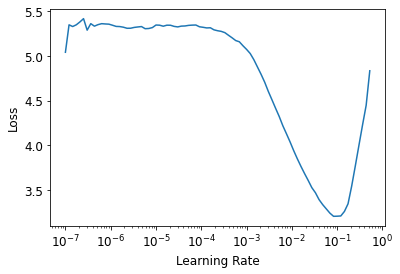

In [39]:
#Finding optimal learning rate using Learning rate finder
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()#Finding min and steepest learning rates

From the plot we can observe that the learning rate values are in range 10^-6 and 10^-3.Initially the
loss is constant at lower learning rates,then it starts decreasing till the point it is minimum and 
then with increase in learning rate,it starts increasing again.The point where it starts increasing is
the around 10^-1 which is a very high learning rate.The optimal learning rate should be such that loss
is decreasing at that point 

In [40]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
#Optimal learning rate is the difference of both

Minimum/10: 8.32e-03, steepest point: 5.25e-03


From the learning rate plot,3*10^-3 seems to be an optimal learning rate from the learning rate plot.
Next we train a model with 3*10^-3 learning rate.Let's see what are the results...

The learning rate finder plot is equally spaced between 10^-6,10^-5.On a linear scale these points are
not equally spaced while on logarithmic scale,these points are equally spaced and that's why the
learning rate finder has a logarithmic scale.

In [41]:
#Finetuning the learner using optimal learning rate
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.329751,0.317736,0.102842,02:43


epoch,train_loss,valid_loss,error_rate,time
0,0.570550,0.398260,0.109608,03:15
1,0.336071,0.241455,0.075101,03:15


The error rate decreases a lot after using optimal learning rate.Choosing an appropriate learning rate
is very important for training model.
In chapter-1,we saw that the neural networks have been in work since 1950s but learning rate finder
was discovered a few years ago in 2015 only.Also the thought that doing such research would require
advanced maths,giant computational resources or huge datasets is not true because Leslie Smith was not
a big scientist or part of Big company instead he was an early researcher.
What we mean to say is that for a breakthrough research big resources are not required only idea and 
vision are important.

We have chosen an optimal learning rate for our model.Let's see how can we fine tune the weights of 
the model..

### Unfreezing and Transfer Learning

Previously we have discussed about Transfer Learning where we use pretrained model trained previously
on millions of images.We use the same model and train it for a different dataset.We had learned 
previously that while optimizing our model we are basically identifying optimal set of weights while
we train our model.So how can we use one set of weights optimized for one dataset for another.
We know that a CNN consists of many linear layers with a nonlinear activation layer between linear 
layers which have softmax as activation function at end.The final layer has a matrix with the number 
of columns such that output size is same as the number of classes in our model.(for classification 
problems).

The final layer in CNN is not of any use for us if we are using pretrained model as it is specifically
used for classifying the images into different classes and it would be specific for every dataset.
Therefore during Transfer Learning the last layer is removed and a new layer with the output size as 
per our requirement is placed instead.

The new layer is initialized with random set of weights.Before fine tuning our model has random output
.We know that initial layers in CNN are responsible for general characters such as edges and borders
and later layers identify the specific characters such as eyes,facial expressions etc.

In the newly added layer there are random weights and therefore while fine-tuning we need to replace
them with the correct set of weights for our particular task.We can do this by allowing optimizier to
freeze the other layers and only update the weights in the randomly added layers.The weights in the 
other part of the neural network are not changed.

Fastai automatically freezes the layers of the pretrained model.When fine_tune is called,it trains the
newly added layers for one epoch and other layers frozen and then unfreezes all the layers and trains
them for the specified number of epochs.This is the default approach but we can also follow other
approaches.The fine_tune method provides many parameters such as number of epochs or Learning rate
which we can change to tune our model.

One of the approach includes using fit_one_cycle method.In this we first train the newly added layers
for number of epochs using fit_one_cycle method.This method is also like fine_tune method used to 
train models.The difference is that it trains early layers with low learning rate and then gradually
increases learning rate and then again decreases.

In [44]:
#Throw last layer,replace with random weights and then train those layers with a number of epochs..
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.135311,0.264579,0.087280,02:41
1,0.518022,0.236035,0.074425,02:42
2,0.313706,0.214558,0.069689,02:41


After training the new layers for some epochs we unfreeze the layers.And then using lr_find we again
find the learning rate as we have more layers to train and weights already trained for some epochs.So
we would find new learning rate

In [45]:
learn.unfreeze()#unfreezing the last layer

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

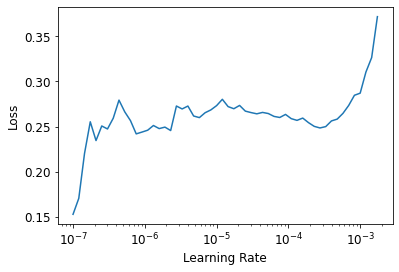

In [46]:
learn.lr_find()#finding new learning rate

This learning rate finder plot is different from the one we had observed before for an untrained model
as there are layers which are already trained for 3 epochs.Here there is a constant pattern in loss 
before there is a sharp increase in loss.A point should be chosen such that it is before that sharp
increase.Here it can be 10^-5.Let's train the whole model now using this learning rate.

In [47]:
#Small learning rate for early layers and bigger for later layers
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.273768,0.209147,0.071719,01:40
1,0.239502,0.208803,0.064953,01:41
2,0.216370,0.201055,0.061570,01:42
3,0.198689,0.196057,0.059540,01:43
4,0.197553,0.195793,0.059540,01:44
5,0.194252,0.197092,0.062246,01:45


The error rate of the model is quite low but it can be improved more.The inner layers of the model
don't require more learning rates as the last layers therefore we can use different learning rates for
different layers.It is called discriminative learning rates.

### Discriminative Learning Rates

In the previous section we trained the new layers for some epochs,found a new learning rate and then 
trained all layers(the new ones and the pretrained weights) for the same learning rate.The learning 
rate for the pretrained layers cannot be same as the later added new layers even if they are trained
for some epochs.

We also know that inner layers are trained for edges,gradients,corners whereas the later layers are
identify specific objects like eyes,ears or sun,moon etc which are very specific and vary from dataset
to dataset.Thus it is logical to use different learning rates for different layers.

Fastai's default approach uses discriminative learning approach.It was primarily used for the ULMFiT
approach for NLP Transfer Learning.This idea was initially shown by Jason Yosinski in one of his 
research works in 2014 that using transfer learning different layers can learn at different rates.

For varying learning rates we can actually pass a range of learning rates through the fit_one_cycle 
method which will thus let initial layers be trained at the lowest learning rate in the range and thus
the subsequent layers will be trained with increasing learning rates equally spaced.

We can thus use this approach to train this model starting with 10^-6 and then increasing the learning
rate for other layers till 10^-4.

In [48]:
#Different layers at different learning rates
learn = cnn_learner(dls, resnet34, metrics=error_rate) #creating learner
learn.fit_one_cycle(3, 3e-3)#Train the new layers for 3 epochs while other layers are frozen
learn.unfreeze()#unfreeze the other pretrained layers
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4)) #use Python slice object to provide range of learning
#rates

epoch,train_loss,valid_loss,error_rate,time
0,1.113035,0.340135,0.112314,01:26
1,0.515133,0.239691,0.080514,01:27
2,0.319145,0.218286,0.068336,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.255743,0.212772,0.067659,01:42
1,0.244339,0.203982,0.064276,01:43
2,0.238857,0.192986,0.061570,01:45
3,0.222231,0.191442,0.058187,01:45
4,0.194355,0.180988,0.053451,01:46
5,0.172234,0.183715,0.056834,01:46
6,0.160897,0.177184,0.056834,01:45
7,0.138398,0.181764,0.054804,01:45
8,0.135183,0.175772,0.050744,01:45
9,0.131089,0.172850,0.054127,01:45


Fastai also lets us visualize the pattern of the training and validation loss using the learn.recorder
.

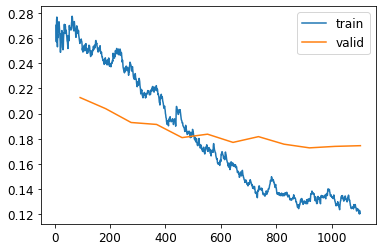

In [50]:
#Error rate is important validation loss gets worse 
#Loss-Approximation of what we care about
learn.recorder.plot_loss()

We can observe that the training loss decreases with epochs but validation loss becomes constant after
certain time and sometimes increases also.This can lead to overfitting.But this doesn't lead to 
accuracy becoming worse.We can observe from the training table that accuracy keeps on improving.That 
is why previously also we mentioned that as metrics accuracy is more important and not loss.Loss is a 
function used for optimizing the weights.

One more thing to keep in mind while we train the model is that for how much time we train it for.That
is controlled by the number of epochs..

### Selecting the Number of Epochs

Most of the times rather than accuracy and generalization we have time as the main constraints while
training model.Initially we should train the model for time as per our requirements,then we should see
training and validation loss plots and metrics specially and if they are improving with more number of
epochs,then can be trained for more epochs.
But the metric may get worse at end of training sometimes.
We should save our model at the end of every epoch and then select the one which provides best metric 
among all the saved models.It is called early stopping.But it never gives good results.One approach 
can be retrain the model from scratch and decide the number of epochs on the basis of where best 
results are obtained.
Sometimes even deeper architectures can also be used.

### Deeper Architectures

Its a general concept that model with more parameters can model data accurately.There are many 
pretrained architectures which have varied number of layers...For example the resnet architecture we
have been using for Image Classifier has variants of 18,34,50,101 and 152 layers.More number of layers
could result in overfitting but because of more number of parameters.
Bigger models are definitely more accurate than small ones as they can learn more specific details and
more inner patterns in the data.

Using a deeper architecture may consume more memory and we may get error such as
```
Cuda runtime error: out of memory
```Then we have to reduce the batch size(by passing bs= through dataloaders) or restart the kernel 
again.Deeper architectures also take long time to train.One technique to solve this problem is to use
mixed-precision training.We can use less precise numbers called fp-16 during training.All GPUs 
generally support a feature called tensor cores which speed up the training process by 2 to 3 times.
Also consume less GPU memory.To use them in fastai  to_fp16() should be added to Learner.(fp16 module
should be imported).
We should try different architecture to train our model so that we can get the best one.

In [54]:
#putting more pairs of non-linear activation functions,non-linearity,more layers
#Bigger models-more parameters,more gradient
from fastai.callback.fp16 import *#Uses half as number of bits consumed
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()#Faster training
learn.fine_tune(6, freeze_epochs=3)
#More number of layers not necessarily don't give correct results everytime

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 4.11 GiB already allocated; 934.40 KiB free; 4.15 GiB reserved in total by PyTorch)

## Conclusion

In this chapter we learnt about presizing images,DataBlock passing and for fitting the model.We also
learnt about finding optimal learning rate,freezing,unfreezing layers,discriminative learning rates,
number of epochs and using deeper architectures.We also discussed about cross entropy loss,negative 
likelihood and softmax function and how we apply it on classification problems with more than two 
categories.
Cross Entropy Loss is a very important aspect of deep learning.For debugging any model,improving its
accuracy or put model into production we would be required to understand loss functions and cross 
entropy loss is something used in almost every classification problem.To understand it better we can 
actually create small tensors and pass it through small functions.
Further in next chapter,we will learn about Datasets,Pandas Library and multilabelled Image 
Classification.

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods is that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

Answers:-

Ans-1.For training model data is distributed into mini-batches for processing on GPU.As item are 
received from Dataloaders they are resized to larger size to ensure they are of same size.After 
arranging them into batches,batch transformations are applied where images are resized to final size
suitable for processing on GPU.Random cropping is done so that there are no empty zones in the images
and important characters are preserved.

Ans-3.Data can be provided in Folders and directories or either in CSV files.

Ans-6.Rotating an image by 45 degrees results in  emptiness in the images leading to loss of training
time.Zooming image causes interpolating pixels which are of lower quality.

Ans-7 dls.show_batch can be used to display data in dataloaders.

Ans-8 DataBlock.summary() helps in debugging a DataBlock and it returns an error if any of the 
operation is wrong or missing.

Ans-9 No a simple baseline model can be trained before thoroughly cleaning the data.Cleaning the data
is gradual process.We can do it simultaeously after observing our previous model metrics or mistakes 
to see what can be corrected.

Ans-10 Negative Likelihood loss and Logarithms are combined in nn.CrossEntropyLoss().

Ans-11.Softmax ensures that all predictions are between 0 and 1 and they also sum to 1.It maps all 
predictions between 0 and 1 so that it becomes easy to activate the next neuron on the basis of the
threshold and also while making predictions for multiclasses(>2),it's easy to define the confidence of
the prediction in terms of probability.That's why it is ensured that predictions for all the classes 
sum to 1.

Ans-12 In case of regression or continuous variables having predictions between 0 and 1 is of no use 
as here we would be measuring the error through the difference between the two values.Sometimes in
hidden or middle layers too when we want non-linearity in the model,ReLU is used which is not between
0 and 1.

Ans-14 We can use torch.where to create loss function for binary problems as it chooses between 
inputs and 1-inputs.But in case of multiple categories,we will have to sum the other probabilites and
then take the difference.Also there will be n number of activations for n classes and it would be 
difficult to interpret which one is more confident of the prediction.

Ans-15 Logarithm is not defined for negative values.

Ans-16 For finding an optimal learning rate from the lr_finder we usually start with a low value for 
inner layers and then subsequently increase it so that it reaches the minimum value of the loss.The
learning rate should not be such high that the loss values become more worse.

Ans-17 fine_tune method by default freezes the pretrained inner layers and trains the model for one 
epoch with randomly added layers.Later these layers are unfrozen and all the layers are trained on 
the same learning rate.

Ans-18 By using ?? in front of any method or function.

Ans-19  Discriminative learning rates is an approach where different layers in network are trained on
different learning rates.For example,inner layers can be trained on small learning rates as they are 
already pretrained on millions of images whereas outer layers are comparatively new and initialized 
with random weights to make them specific as per our Dataset.

Ans-20  A python slice object is passed with learning rates in our learner's fine_tune or 
fit_one_cycle method.It basically does descriminative learning and trains a few initial layers with 
less learning rate which keeps increasing with subsequent layers as they are equally spaced in between
the learning rates ranges we pass as a Python slice object in the fit_one_cycle method.

Ans-21 In 1cycle training we run and save the model results after every epoch and then we can choose
the best accuracy from all the models saved during each epoch.It is called Early Stopping but this 
approach rarely gives good results as the epochs in the middle are shown even before our learning 
rates can reach a small value and give the best result.

Ans-22.There is a difference between the number of layers in the pretrained model Resnet variants.

Ans-23 to_fp16 results in mixed precision training.Deeper architecture models take a lot of memory and
time for training.To consume less memory and to speed up the process using less precise numbers we 
just pass to_fp16 after the learner creation.

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.